In [9]:
import pandas as pd
import numpy as np 
from glob import glob
import matplotlib.pyplot as plt 
def get_df_from_path(path):
    all_files= glob(path + "/*/*.csv")
    li = []
    for file in all_files:
        date = file.split("/")[-1].split(".")[0]
        temp_df = pd.read_csv(file)
        temp_df["Date"] = date
        li.append(temp_df)
    df = pd.concat(li, axis=0, ignore_index=True)
    df = df[(df["Length"] > 0) & (df["Ratio"] > 0 )& (df["Ratio"]<1)]
    return df

def plot_dfs_hist(dfs):
    for (df,name) in dfs:
        plt.hist(x = df["Ratio"], bins = 20, alpha = 0.4, label = name, density = True)
    plt.title("Distribution of word ratio per newspaper")
    plt.xlabel("Word ratio")
    plt.ylabel("Frequency")
    plt.legend()
    plt.savefig('histo.png')
    plt.show()


def plot_dfs_wr(dfs):
    for (df, name )in dfs:
        plt.scatter(x = df["Length"], y = df["Ratio"],label = name, alpha = 0.3)
        plt.title(f"Word ratio w.r.t. frequency for the newspaper {name}")
        plt.xlabel("Word ratio")
        plt.ylabel("Length")
        plt.savefig(f'dwr{name}.png')
        plt.show()

path = "./results/NYT/1920"
df = get_df_from_path(path)
df

,Text,Ratio,Length,Date
0,WEATHER FOR and much cooler to gales fail HigP...,0.911111,45,1920\10\01
1,If Manufacturing Holding Its Own in Spite of j...,0.932203,236,1920\10\01
2,I viewpoint Market Reflect Uoort Crop r Price ...,0.901754,285,1920\10\01
3,were never more Grains Hnrkrtftl Mlo vljr jh T...,0.925620,242,1920\10\01
4,of price reduction from manufacturer and whole...,0.853448,116,1920\10\01
...,...,...,...,...
120675,1 Q THE WORLD STEAMSHII 1 ritSIOXS and TOrIIS ...,0.847368,190,1920\12\31
120676,Zeeland 12 Noon 22 26 Apr 2 Gothland 12 Noon 1...,0.863469,271,1920\12\31
120677,SAXONIA Plymouth Cherbourg and Hamburg Mar 1 A...,0.764706,187,1920\12\31
120678,NEW YORK BORDEAUX T V ILC caroiint 31 12 I HAM...,0.757009,214,1920\12\31


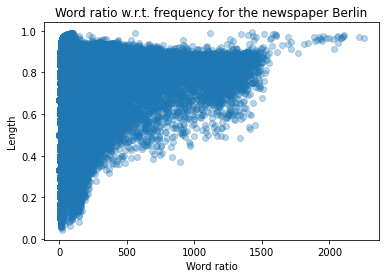

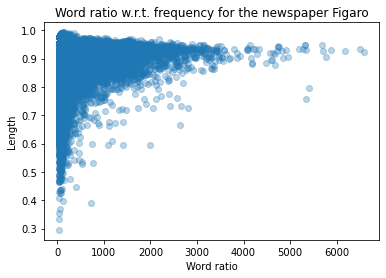

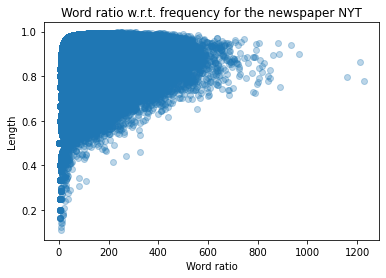

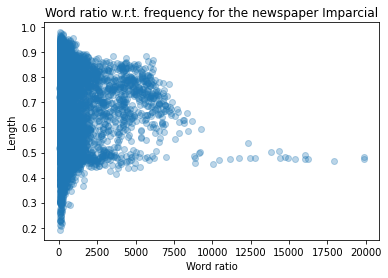

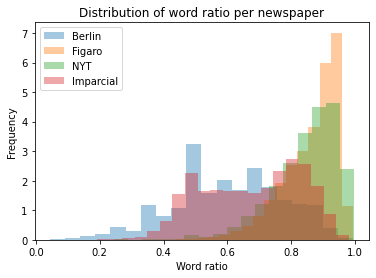

In [2]:
paths = [
    "./results/Berlin/1879",
    "./results/Figaro/1898",
    "./results/NYT/1920",
    "./results/Imparcial/1898"
]
newspapers = [path.split("/")[2] for path in paths] 
dfs = [(get_df_from_path(path),newspapers[i]) for i,path in enumerate(paths)]
plot_dfs_wr(dfs)
plot_dfs_hist(dfs)

In [14]:
path = "./results/NYT/1920"
df = get_df_from_path(path)
bad = df[(df["Ratio"] < 0.6) & (df["Length"] > 20)][["Text", 'Date']]
bad.to_csv("bad_ocr.txt", index= False)